In [57]:
from simsopt._core import load
from simsopt.mhd import Vmec
from simsopt.geo import SurfaceRZFourier

import numpy as np
import matplotlib.pyplot as plt
from simsopt.objectives.fluxobjective import SquaredFlux

from simsopt.geo import PortSize

%matplotlib widget

In [69]:
v = Vmec('input.LandremanPaul2021_QH')
surf = v.boundary

NN = 1
bs = load(f'output_nc={NN}/biotsavart.json')

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  VMEC OUTPUT FILES ALREADY EXIST: OVERWRITING THEM ...
  SEQ =    1 TIME SLICE  0.0000E+00
  PROCESSING INPUT.LandremanPaul2021_QH
  THIS IS PARVMEC (PARALLEL VMEC), VERSION 9.0
  Lambda: Full Radial Mesh. L-Force: hybrid full/half.

  COMPUTER: arm64-apple-darwin20.0.0   OS:    RELEASE:   DATE = Feb 02,2024  TIME = 22:12:56


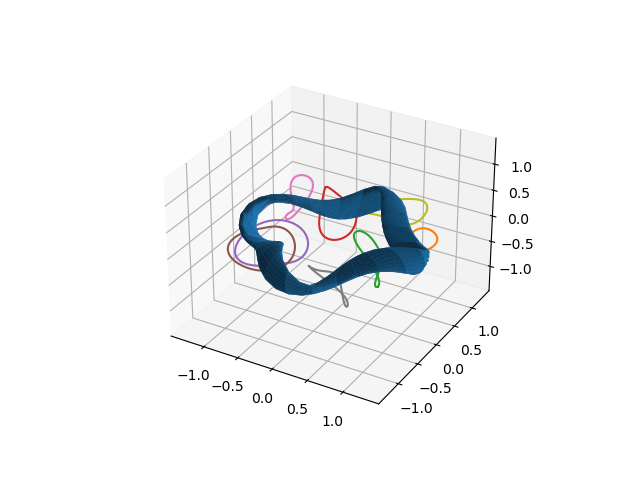

In [70]:
surf.plot(close=True, show=False)
ax = plt.gca()
for c in bs.coils:
    c.curve.plot(ax=ax,show=False)

Text(0.5, 0, '$\\theta$')

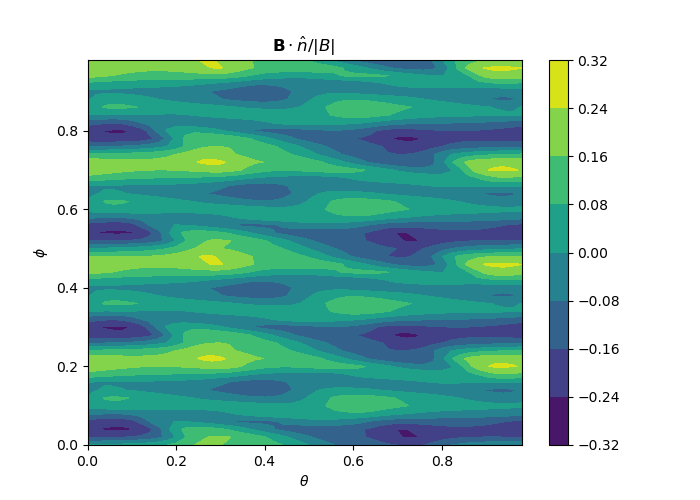

In [71]:
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(7,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

In [5]:
print(np.max(np.abs(Bdotn / modB)))

0.03713844983622677


In [16]:
maxBn = []
sqflux = []
ncoils = [1,2,3,4,5,6,7]

nphi = 16
ntheta = 42
three_halves_field_period_surf = SurfaceRZFourier(mpol=surf.mpol,ntor=surf.ntor, nfp=surf.nfp, 
                        quadpoints_phi=np.linspace(0,3/(2*surf.nfp),3*nphi), 
                        quadpoints_theta=np.linspace(0,1,ntheta))   
for mm in range(0,surf.mpol+1):
    for nn in range(-surf.ntor,surf.ntor+1):
        if mm==0 and nn<0:
            continue
        three_halves_field_period_surf.set(f'rc({mm},{nn})', surf.get(f'rc({mm},{nn})'))
        if not (mm==0 and nn==0):
            three_halves_field_period_surf.set(f'zs({mm},{nn})', surf.get(f'zs({mm},{nn})'))
three_halves_field_period_surf.extend_via_normal( 0.12 )
vessel = three_halves_field_period_surf

port_sizes = []

for ncoil in ncoils:
    bs = load(f'output_nc={ncoil}/biotsavart.json')
    theta = surf.quadpoints_theta
    phi = surf.quadpoints_phi
    ntheta = theta.size
    nphi = phi.size
    bs.set_points(surf.gamma().reshape((-1,3)))
    Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)
    modB = bs.AbsB().reshape((nphi,ntheta))

    maxBn.append(np.max(np.abs(Bdotn / modB)))

    Jf = SquaredFlux(surf, bs)
    sqflux.append(Jf.J())

    coils = bs.coils[:ncoil] + bs.coils[-ncoil:] + bs.coils[2*ncoil:3*ncoil]
    curves = [c.curve for c in coils]
    port = PortSize( curves, vessel )
    rp, pos = port.find_max_port_size_and_position()

    port_sizes.append(rp)
    
maxBn = np.array(maxBn)
sqflux = np.array(sqflux)
port_sizes = np.array(port_sizes)

/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may 

In [17]:
maxBn

array([0.26111139, 0.08978817, 0.02242039, 0.00549943, 0.00252235,
       0.01290962, 0.03713845])

In [18]:
sqflux

array([5.05407568e-04, 2.18050939e-04, 2.95526446e-05, 2.67404979e-06,
       7.65724573e-07, 1.64894931e-05, 2.30856628e-04])

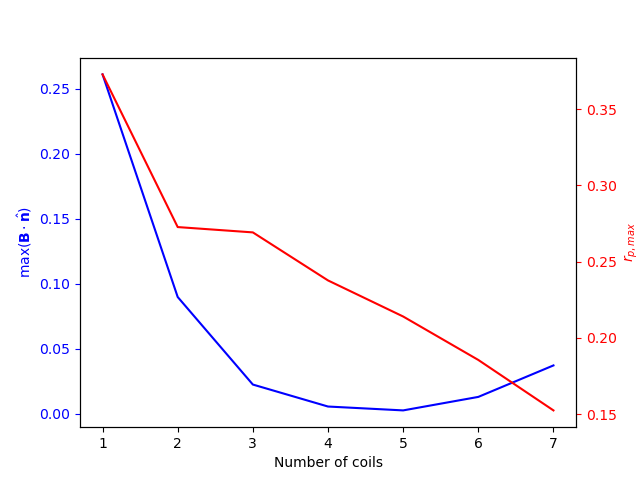

In [22]:
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first y-axis data
ax1.plot(ncoils, maxBn, color='blue')
ax1.set_xlabel('Number of coils')
ax1.set_ylabel(r'$\max(\mathbf{B}\cdot\hat{\mathbf{n}})$', color='blue')
ax1.tick_params('y', colors='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(ncoils, port_sizes, color='red')
ax2.set_ylabel(r'$r_{p,max}$', color='red')
ax2.tick_params('y', colors='red')

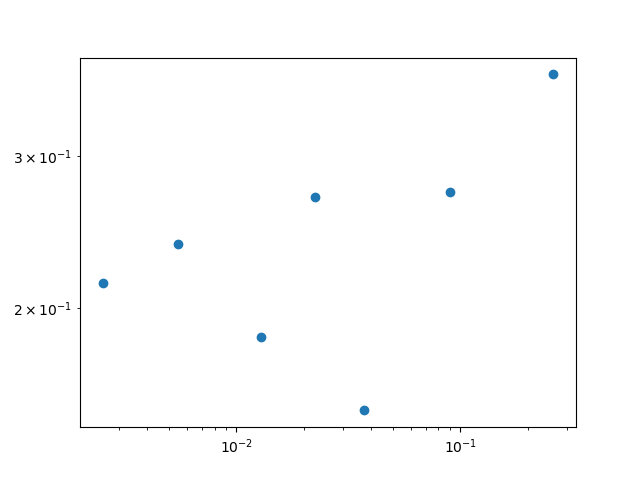

In [27]:
ind = np.argsort(maxBn)
plt.figure()
plt.loglog(maxBn[ind], port_sizes[ind], 'o', label=r'$r_{p,max}$')

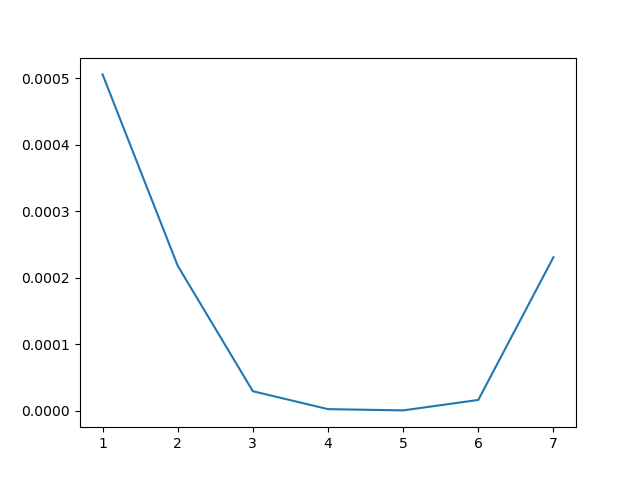

In [10]:
plt.figure()
plt.plot(ncoils, sqflux)

In [11]:
nphi = 10
ntheta = 32
three_halves_field_period_surf = SurfaceRZFourier(mpol=surf.mpol,ntor=surf.ntor, nfp=surf.nfp, 
                        quadpoints_phi=np.linspace(0,3/(2*surf.nfp),3*nphi), 
                        quadpoints_theta=np.linspace(0,1,ntheta))   
for mm in range(0,surf.mpol+1):
    for nn in range(-surf.ntor,surf.ntor+1):
        if mm==0 and nn<0:
            continue
        three_halves_field_period_surf.set(f'rc({mm},{nn})', surf.get(f'rc({mm},{nn})'))
        if not (mm==0 and nn==0):
            three_halves_field_period_surf.set(f'zs({mm},{nn})', surf.get(f'zs({mm},{nn})'))
three_halves_field_period_surf.extend_via_normal( 0.12 )
vessel = three_halves_field_period_surf


bs = load(f'output_nc={NN}/biotsavart.json')
coils = bs.coils[:NN] + bs.coils[-NN:] + bs.coils[2*NN:3*NN]
curves = [c.curve for c in coils]

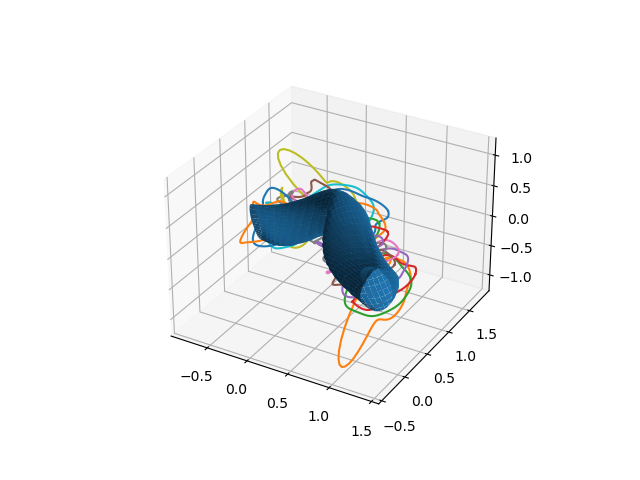

In [12]:
vessel.plot(close=True, show=False)
ax = plt.gca()
for c in curves:
    c.plot(ax=ax,show=False)

In [13]:
port = PortSize( curves, vessel )

/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may be poorly conditioned
  self.update_surface(surf)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:177: RankWarning: Polyfit may 

In [14]:
rp, pos = port.find_max_port_size_and_position()

/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:397: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(gamma_proj[ind_below,1], gamma_proj[ind_below,2], s=5, marker='^', c=col)
/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/accessibility.py:398: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(gamma_proj[ind_above,1], gamma_proj[ind_above,2], s=5, marker='o', c=col)
/Users/antoine

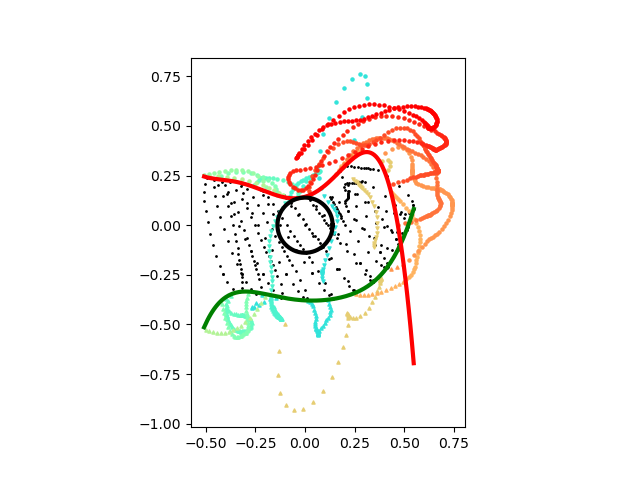

In [15]:
port.plot_port(pos[0], pos[1], rp=rp)